<a href="https://colab.research.google.com/github/OumGhaith/skills-introduction-to-github/blob/main/MobileNet_V2_Steel_Inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transforms (same as DeiT)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Load datasets
train_dataset = ImageFolder('/content/drive/MyDrive/steel_images/train_dataset', transform=transform)
val_dataset   = ImageFolder('/content/drive/MyDrive/steel_images/test_dataset', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training images: {len(train_dataset)}, Validation images: {len(val_dataset)}")
print("Classes:", train_dataset.classes)


Training images: 1440, Validation images: 360
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [3]:
# Load pretrained MobileNetV2
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Replace classifier for 6 classes
model.classifier[1] = torch.nn.Linear(model.last_channel, len(train_dataset.classes))

model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 113MB/s]


In [4]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20

train_losses = []
val_losses = []


In [5]:
for epoch in range(1, num_epochs+1):
    model.train()
    running_train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch} — Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1 — Train Loss: 0.8098 | Val Loss: 0.2276
Epoch 2 — Train Loss: 0.1432 | Val Loss: 0.0527
Epoch 3 — Train Loss: 0.0854 | Val Loss: 0.0425
Epoch 4 — Train Loss: 0.0609 | Val Loss: 0.0221
Epoch 5 — Train Loss: 0.0481 | Val Loss: 0.0057
Epoch 6 — Train Loss: 0.0352 | Val Loss: 0.0126
Epoch 7 — Train Loss: 0.0448 | Val Loss: 0.0183
Epoch 8 — Train Loss: 0.0331 | Val Loss: 0.0120
Epoch 9 — Train Loss: 0.0277 | Val Loss: 0.0080
Epoch 10 — Train Loss: 0.0189 | Val Loss: 0.0098
Epoch 11 — Train Loss: 0.0192 | Val Loss: 0.0046
Epoch 12 — Train Loss: 0.0248 | Val Loss: 0.0443
Epoch 13 — Train Loss: 0.0163 | Val Loss: 0.0093
Epoch 14 — Train Loss: 0.0087 | Val Loss: 0.0036
Epoch 15 — Train Loss: 0.0086 | Val Loss: 0.0010
Epoch 16 — Train Loss: 0.0108 | Val Loss: 0.0034
Epoch 17 — Train Loss: 0.0072 | Val Loss: 0.0011
Epoch 18 — Train Loss: 0.0282 | Val Loss: 0.0122
Epoch 19 — Train Loss: 0.0094 | Val Loss: 0.0024
Epoch 20 — Train Loss: 0.0064 | Val Loss: 0.0013


In [6]:
# Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model size on disk
import tempfile, os
with tempfile.NamedTemporaryFile(delete=False) as tmpfile:
    torch.save(model.state_dict(), tmpfile.name)
    model_size_mb = os.path.getsize(tmpfile.name)/1e6

# Inference time per image
import time
model.eval()
dummy_img, _ = val_dataset[0]
dummy_img = dummy_img.unsqueeze(0).to(device)
start = time.time()
_ = model(dummy_img)
inf_time_ms = (time.time() - start) * 1000

print(f"Total Params: {total_params}, Trainable Params: {trainable_params}")
print(f"Model Size: {model_size_mb:.2f} MB, Inference Time: {inf_time_ms:.2f} ms")


Total Params: 2231558, Trainable Params: 2231558
Model Size: 9.17 MB, Inference Time: 66.51 ms


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.0 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training images: 1440, Validation images: 360
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Epoch 1 — Train Loss: 0.8153 | Val Loss: 0.2202
Epoch 2 — Train Loss: 0.1544 | Val Loss: 0.0564
Epoch 3 — Train Loss: 0.0821 | Val Loss: 0.0319
Epoch 4 — Train Loss: 0.0503 | Val Loss: 0.0309
Epoch 5 — Train Loss: 0.0486 | Val Loss: 0.0237
Epoch 6 — Train Loss: 0.0380 | Val Loss: 0.0221
Epoch 7 — Train Loss: 0.0278 | Val Loss: 0.0047
Epoch 8 — Train Loss: 0.0407 | Val Loss: 0.0086
Epoch 9 — Train Loss: 0.0250 | Val Loss: 0.0057
Epoch 10 — Train Loss: 0.0211 | Val Loss: 0.0054
Epoch 11 — Train Loss: 0.0170 | Val Loss: 0.0123
Epoch 12 — Train Loss: 0.0216 | Val Loss: 0.0096
Epoch 13 — Train Loss: 0.0073 | Val Loss: 0.0182
Epoch 14 — Train Loss

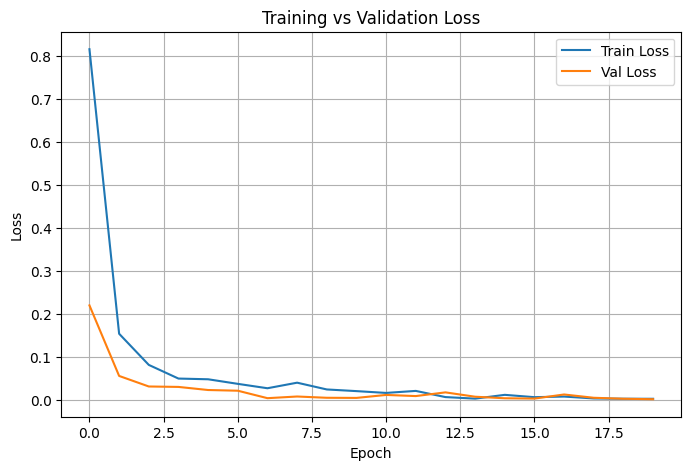

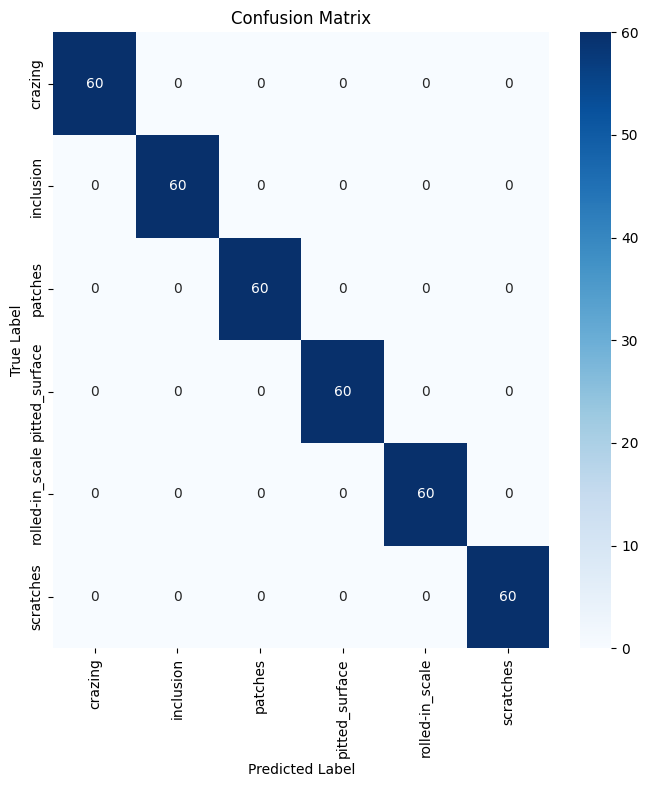

✅ Model saved at: /content/drive/MyDrive/steel_images/mobilenetv2_model.pt


In [7]:
#training, evaluation, metrics, plots, and report === 1️⃣ Install & Import Dependencies ===
!pip install torch torchvision torchmetrics scikit-learn matplotlib seaborn

import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, auc, precision_recall_curve)
import time, os, tempfile, random
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# === 2️⃣ Load & Preprocess Images ===
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = ImageFolder('/content/drive/MyDrive/steel_images/train_dataset', transform=transform)
val_dataset   = ImageFolder('/content/drive/MyDrive/steel_images/test_dataset', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training images: {len(train_dataset)}, Validation images: {len(val_dataset)}")
print("Classes:", train_dataset.classes)

# === 3️⃣ Load Pretrained MobileNetV2 and Modify Head ===
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.last_channel, len(train_dataset.classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# === 4️⃣ Define Loss & Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20

train_losses, val_losses = [], []

# === 5️⃣ Training Loop ===
for epoch in range(1, num_epochs+1):
    model.train()
    running_train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0
    all_true, all_pred, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_true.extend(labels.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch} — Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# === 6️⃣ Evaluation Metrics ===
all_true = np.array(all_true)
all_pred = np.array(all_pred)
all_probs = np.array(all_probs)

acc = accuracy_score(all_true, all_pred)*100
precision_macro = precision_score(all_true, all_pred, average='macro')*100
recall_macro    = recall_score(all_true, all_pred, average='macro')*100
f1_macro        = f1_score(all_true, all_pred, average='macro')*100
report = classification_report(all_true, all_pred, output_dict=True, digits=4)
cm = confusion_matrix(all_true, all_pred)

# Per-class F1
per_class_f1 = {str(i): report[str(i)]['f1-score']*100 for i in range(len(train_dataset.classes))}

# ROC-AUC
try:
    ohe_true = np.eye(len(cm))[all_true]
    auc_score = roc_auc_score(ohe_true, all_probs, multi_class='ovr')*100
except:
    auc_score = None

print("=== Validation Evaluation Metrics ===")
print(f"Accuracy: {acc:.2f}%")
print(f"Macro Precision: {precision_macro:.2f}%")
print(f"Macro Recall: {recall_macro:.2f}%")
print(f"Macro F1: {f1_macro:.2f}%")
print(f"Per-Class F1: {per_class_f1}")
print(f"ROC-AUC (macro): {auc_score if auc_score else 'N/A'}%")
print("Confusion Matrix:\n", cm)

# === 7️⃣ Efficiency Metrics ===
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

with tempfile.NamedTemporaryFile(delete=False) as tmpfile:
    torch.save(model.state_dict(), tmpfile.name)
    model_size_mb = os.path.getsize(tmpfile.name)/1e6

# Inference time
dummy_img, _ = val_dataset[0]
dummy_img = dummy_img.unsqueeze(0).to(device)
start = time.time()
_ = model(dummy_img)
inf_time_ms = (time.time() - start)*1000

print("\n=== Efficiency Metrics ===")
print(f"Total Params: {total_params}")
print(f"Trainable Params: {trainable_params}")
print(f"Model Size: {model_size_mb:.2f} MB")
print(f"Average Inference Time per Image: {inf_time_ms:.2f} ms")

# === 8️⃣ Plot Loss Curves ===
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# === 9️⃣ Confusion Matrix Heatmap ===
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# === 10️⃣ Save Model & Plots to Drive ===
save_path = "/content/drive/MyDrive/steel_images/mobilenetv2_model.pt"
torch.save(model.state_dict(), save_path)
print("✅ Model saved at:", save_path)


In [8]:
import torch
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform (same as before)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Datasets
train_dataset = ImageFolder('/content/drive/MyDrive/steel_images/train_dataset', transform=transform)
val_dataset   = ImageFolder('/content/drive/MyDrive/steel_images/test_dataset', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load MobileNetV2
model = models.mobilenet_v2(weights=None, num_classes=6)
model.load_state_dict(torch.load("/content/drive/MyDrive/steel_images/mobilenetv2_model.pt"))
model.to(device)
model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc

all_true = []
all_pred = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_true = np.array(all_true)
all_pred = np.array(all_pred)
all_probs = np.array(all_probs)

# Accuracy, Macro metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(all_true, all_pred)*100
precision_macro = precision_score(all_true, all_pred, average='macro')*100
recall_macro    = recall_score(all_true, all_pred, average='macro')*100
f1_macro        = f1_score(all_true, all_pred, average='macro')*100
cm = confusion_matrix(all_true, all_pred)
report = classification_report(all_true, all_pred, digits=4)


<Figure size 1000x600 with 0 Axes>

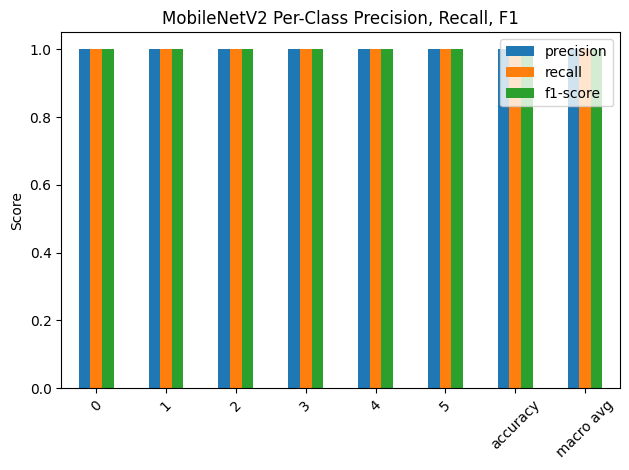

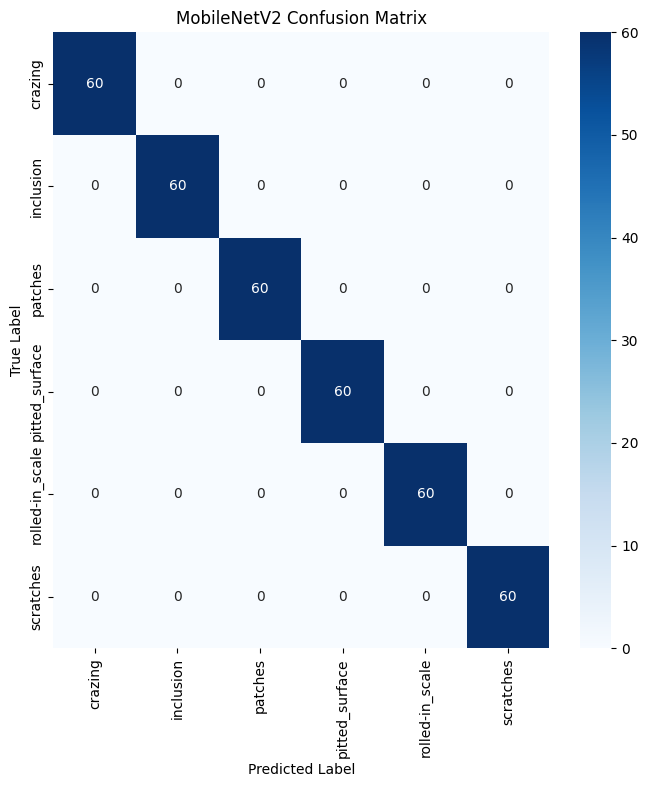

<Figure size 1200x800 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Per-class F1 bars
from sklearn.metrics import classification_report
report_dict = classification_report(all_true, all_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose().iloc[:-1, :3]

plt.figure(figsize=(10,6))
df_report[['precision','recall','f1-score']].plot(kind='bar')
plt.title("MobileNetV2 Per-Class Precision, Recall, F1")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("MobileNetV2 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Show misclassified images
misclassified = [(img, t, p) for i, (img, t) in enumerate(val_dataset)
                 if (p:=torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).item()) != t]

fig = plt.figure(figsize=(12,8))
for i in range(min(6, len(misclassified))):
    img, true_label, pred_label = misclassified[i]
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(img.permute(1,2,0).cpu().numpy()*0.5+0.5)
    ax.set_title(f"True: {train_dataset.classes[true_label]}\nPred: {train_dataset.classes[pred_label]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


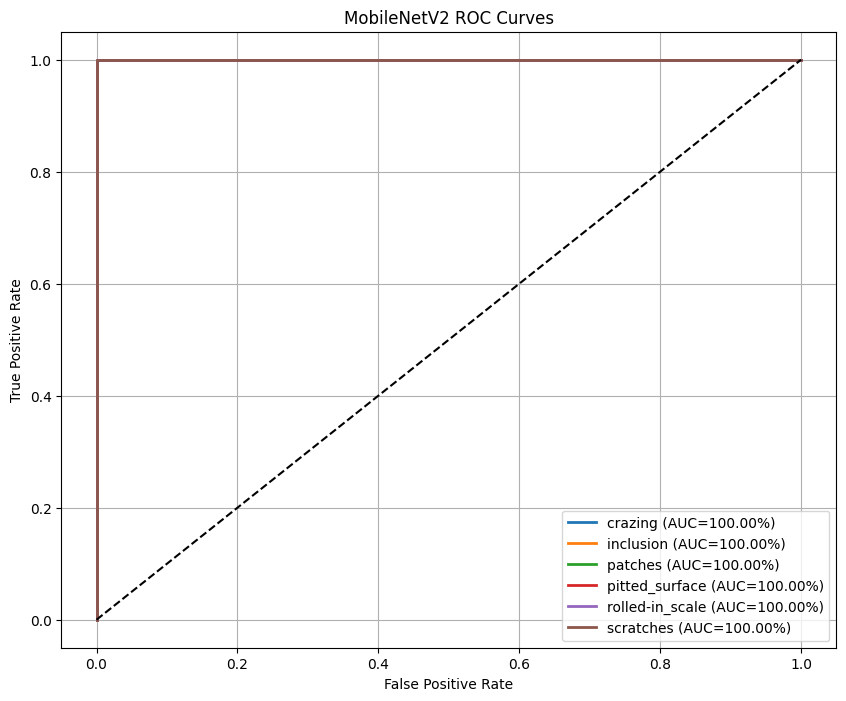

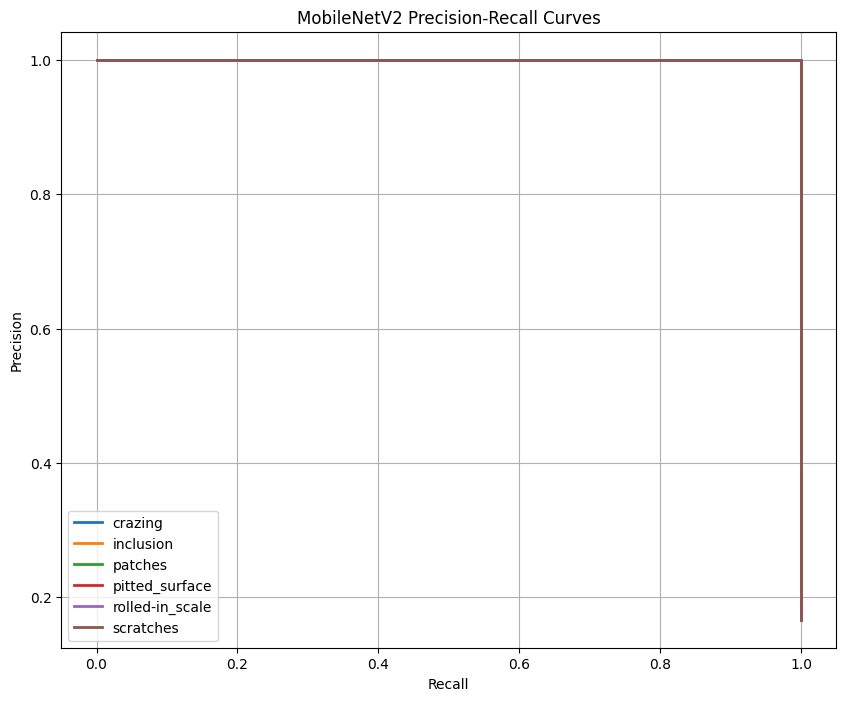

In [11]:
from sklearn.preprocessing import label_binarize

y_true_ohe = label_binarize(all_true, classes=np.arange(len(train_dataset.classes)))
n_classes = y_true_ohe.shape[1]

# ROC Curve
plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_ohe[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{train_dataset.classes[i]} (AUC={roc_auc*100:.2f}%)")
plt.plot([0,1],[0,1],'k--')
plt.title("MobileNetV2 ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10,8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_ohe[:, i], all_probs[:, i])
    plt.plot(recall, precision, lw=2, label=train_dataset.classes[i])
plt.title("MobileNetV2 Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


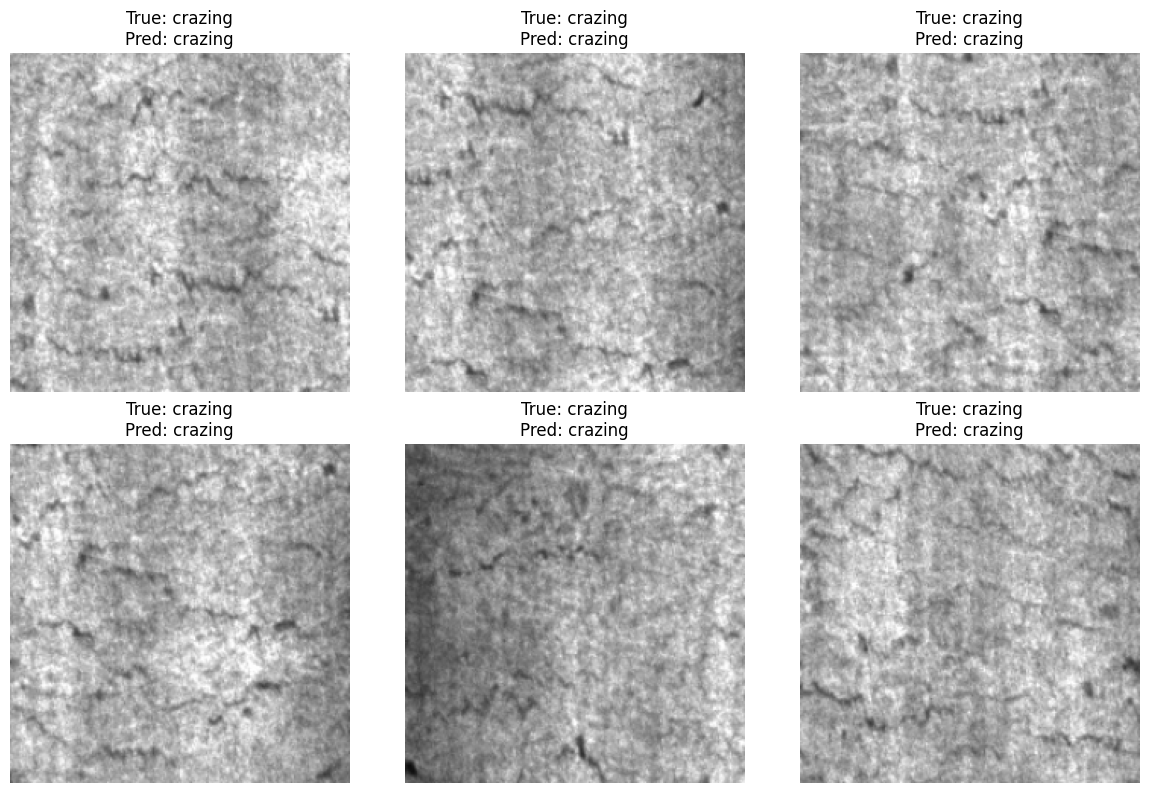

In [13]:
# =============================
# Show Well-Classified Images
# =============================
# Collect well-classified images
wellclassified = [(img, t, torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).item())
                  for i, (img, t) in enumerate(val_dataset)
                  if torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).item() == t]

# Display a few examples
fig = plt.figure(figsize=(12,8))
for i in range(min(6, len(wellclassified))):
    img, true_label, pred_label = wellclassified[i]
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(img.permute(1,2,0).cpu().numpy()*0.5 + 0.5)  # Undo normalization
    ax.set_title(f"True: {train_dataset.classes[true_label]}\nPred: {train_dataset.classes[pred_label]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [14]:
!git clone https://github.com/YOUR_USERNAME/YOUR_REPO.git
!cp /content/drive/MyDrive/steel_images/mobilenetv2_model.pt YOUR_REPO/
!cd YOUR_REPO && git add .
!cd YOUR_REPO && git commit -m "Add MobileNetV2 steel defect model"
!cd YOUR_REPO && git push origin main


Cloning into 'YOUR_REPO'...
fatal: could not read Username for 'https://github.com': No such device or address
cp: cannot create regular file 'YOUR_REPO/': Not a directory
/bin/bash: line 1: cd: YOUR_REPO: No such file or directory
/bin/bash: line 1: cd: YOUR_REPO: No such file or directory
/bin/bash: line 1: cd: YOUR_REPO: No such file or directory
